# Film Plot Synopses (and stuff) as Predictors of Critical Reception

In [201]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import enchant
english_d = enchant.Dict("en_US")
import re
import gensim
from gensim import corpora, models, similarities
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pyLDAvis
import pyLDAvis.gensim

In [2]:
imdb = pd.read_csv('imdb_5000_movies.csv') # Just a Kaggle dataset.

The best part of this kaggle dataset is that it provides 5k+ IMdB movie ID's, which we parse and pass to the Open Movie Database API for an even richer data set. Keys to this API cost a whole dollar. Here we parse out those IMdB ID's.

In [3]:
imdb_ids = [imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0] for i in range(len(imdb))]

### Insert code into omdb api and turn each one into its own text file

This is where we persist our API queries to files, so that we don't run into query limits and get locked out of our dataset. Our API key has been removed from this notebook.

In [4]:
# for id in imdb_ids:

#     request = requests.get(f'http://www.omdbapi.com/?i={id}&plot=full&apikey={API_KEY}').json()
#     text = str(request)  
    
#     f = open(f'movie_{id}', 'w+')
#     f.write(text)
#     f.close()

### Create new dataframe with relevant columns

Now that we've saved a bunch of files containing data about movies, we'll read them back into pandas in a tidy way:

In [5]:
#create empty dataframe with relevant columns

df = pd.DataFrame(columns=['Title', 'Year', 'ID', 'Plot', 'Genre', 'Production', 
                           'Director', 'Actor_1_name', 'Actor_1_fb_likes', 'Actor_2_name', 
                           'Actor_2_fb_likes', 'Actor_3_name', 'Actor_3_fb_likes', 'Budget', 
                           'Rated', 'Language', 'imdbRating'])

### Drawing from both the kaggle dataset and the OMdB API Data

In [6]:
for i in range(len(imdb_ids)):
    id = imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0]
    x_file = open(os.path.join('Movies', f"movie_{id}"), "r")    #open up the movie's text file
    movie_text = x_file.readlines()[0]
    dict = eval(movie_text)    #turn string back to dictionary
    dict['Plot'] = dict['Plot'].replace("\'", "'")    #clean up
    df = df.append({'Title': dict['Title'], 'Year': dict['Year'], 'ID': id, 
                    'Plot': dict['Plot'], 'Genre': dict['Genre'], 
                    'imdbRating': dict['imdbRating'], 
                    'Director': imdb.iloc[i,:].loc['director_name'], 
                    'Actor_1_name':imdb.iloc[i,:].loc['actor_1_name'], 
                    'Actor_1_fb_likes':imdb.iloc[i,:].loc['actor_1_facebook_likes'], 
                    'Actor_2_name':imdb.iloc[i,:].loc['actor_2_name'], 
                    'Actor_2_fb_likes':imdb.iloc[i,:].loc['actor_2_facebook_likes'], 
                    'Actor_3_name':imdb.iloc[i,:].loc['actor_3_name'], 
                    'Actor_3_fb_likes':imdb.iloc[i,:].loc['actor_3_facebook_likes'], 
                    'Budget':imdb.iloc[i,:].loc['budget'], 'Language':dict['Language'], 
                    'Rated':dict['Rated']}, ignore_index=True)    #add to dataframe

### Parsing out Genres as one-hot Columns:

In [7]:
li = []
for i in range(len(df)):
    movie_genres = df.iloc[i]['Genre'].split(', ')
    li.append(movie_genres)
    
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

for genre in final_genres:
    list = []
    for movie in li:
        if genre in movie:
            list.append(1)
        else:
            list.append(0)
    df[genre] = list

### Remove movies with null plots and ratings, convert ratings into binary

In [8]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)


In [9]:
df = df.reset_index()

In [10]:
df = df.drop(['index'], axis=1)

In [11]:
df[:3]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,...,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,binary_target
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,...,0,0,0,0,0,0,0,0,0,1
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,...,0,0,0,0,0,0,0,0,0,1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,...,0,0,0,0,0,0,1,0,0,1


### Creating a fresh DataFrame with Just the Features we Want

In [12]:
main_df = pd.DataFrame()

In [13]:
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

In [14]:
main_df[:3]

,Year,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,binary_target
0,2009,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2007,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2015,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [15]:
df.plot.scatter(x='Actor_1_fb_likes',
                    y='imdbRating') # Just spotting some outliers...this prompted us to log transform fb_likes

### Log Transforming Actor Facebook Likes for use as a Feature

In [16]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

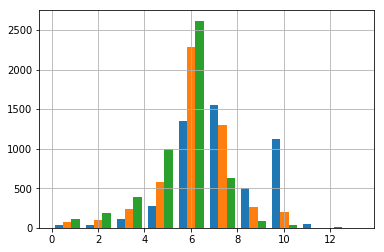

In [17]:
pd.Series(actor_likes).hist()

In [18]:
main_df = main_df.join(actor_likes)

In [19]:
main_df[:3]

,Year,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Romance,Sci_Fi,Sport,Thriller,War,Western,binary_target,Actor_1_fb_likes_logged,Actor_2_fb_likes_logged,Actor_3_fb_likes_logged
0,2009,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6.908755,6.842683,6.752270
1,2007,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,10.596660,8.517393,6.908755
2,2015,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,9.305741,5.976351,5.087596


### Incorporating Natural Language Processing with Plot Synopses

#### Setting up Lemmatization / Normalization Functions

In [20]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(plot_list):
    lemmatized_plots = []
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower())   #make plot summary all lowercase and lemmatize
        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        
        lemmatizer = WordNetLemmatizer()
        
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower]    #lemmatize each word based on part of speech
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        #filter for words that match regex pattern
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))    #define regular expression pattern
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        #filter out stop words
        stop_words = set(stopwords.words('english'))
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        
        lemmatized_plots.append(lemmatized_string)
        
        
    return lemmatized_plots

In [21]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all the plots.

### Running the Lemmatizer

In [22]:
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [23]:
#term frequency = number of times a word appears in a document / number of words in document
#inverse document frequency = log base e(number of ducuments / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

(5037, 13807)


Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA - Clustering Documents by Topic

We tried running a topic modeling algorithm over our corpus of text. "Gensim" clusters words that appear together frequently across several documents. The clusters can be interpreted as general themes, and each movie has weights of how much it belongs to each theme. These weights are then re-incorporated as features in our dataset.

In [24]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [25]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [26]:
NUM_TOPICS = 30 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('model5.gensim')

In [27]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

[(19, '0.031*"life" + 0.018*"family" + 0.014*"relationship" + 0.013*"love"'),
 (7, '0.027*"john" + 0.013*"child" + 0.009*"grace" + 0.007*"call"'),
 (13, '0.024*"life" + 0.017*"town" + 0.010*"car" + 0.009*"girlfriend"'),
 (17, '0.013*"man" + 0.012*"kill" + 0.012*"police" + 0.010*"one"'),
 (18, '0.035*"school" + 0.021*"high" + 0.012*"go" + 0.012*"life"'),
 (3, '0.015*"harry" + 0.011*"documentary" + 0.010*"make" + 0.010*"go"'),
 (24, '0.040*"war" + 0.021*"world" + 0.013*"soldier" + 0.013*"army"'),
 (25, '0.018*"mike" + 0.011*"gang" + 0.010*"drug" + 0.007*"money"'),
 (4, '0.018*"film" + 0.017*"world" + 0.017*"vampire" + 0.012*"human"'),
 (8, '0.018*"jerry" + 0.014*"big" + 0.012*"story" + 0.011*"dance"'),
 (23, '0.013*"road" + 0.012*"trip" + 0.011*"get" + 0.009*"family"'),
 (12, '0.025*"dog" + 0.014*"series" + 0.014*"josh" + 0.014*"jenny"'),
 (5, '0.009*"world" + 0.009*"nuclear" + 0.009*"gold" + 0.008*"dragon"'),
 (6, '0.027*"earth" + 0.019*"alien" + 0.016*"planet" + 0.012*"human"'),
 (15, 

In [206]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/Users/rob/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
29    -0.165958  0.039386       1        1  13.075333
17    -0.059340  0.139476       2        1   9.262498
19    -0.180837 -0.042924       3        1   7.844336
1     -0.137950  0.016715       4        1   6.212696
10    -0.121712 -0.006726       5        1   5.945950
27    -0.105418  0.071237       6        1   5.590833
26    -0.138576  0.034158       7        1   4.879561
11    -0.007467 -0.082997       8        1   3.311204
18    -0.132839 -0.042689       9        1   3.306044
24     0.135496  0.097628      10        1   2.903077
6     -0.028144  0.028508      11        1   2.887924
3     -0.072987 -0.056332      12        1   2.648461
4      0.139329  0.025619      13        1   2.270906
22     0.011283  0.081689      14        1   2.236439
9     -0.051749  0.050707      15        1   2.235076
25     0.081220  0.155714      16        1   2.204601
14    -0.000024  0.058644      17        1   2.121588
20     0.004277 -0.071096      18        1   2.096656
21     0.021939  0.057069      19        1   2.080104
23    -0.026851 -0.070934      20        1   1.957906
5      0.166162  0.097558      21        1   1.901221
13    -0.037738 -0.120666      22        1   1.877415
0      0.038156 -0.001833      23        1   1.849050
7      0.005910 -0.050439      24        1   1.796863
15     0.089130  0.027891      25        1   1.665162
28    -0.023743 -0.109648      26        1   1.394789
2      0.114884  0.006223      27        1   1.226548
16     0.196850 -0.017060      28        1   1.222919
8      0.101772 -0.192102      29        1   1.027784
12     0.184925 -0.122774      30        1   0.967057, topic_info=      Category         Freq          Term        Total  loglift  logprob
term                                                                    
244    Default   808.000000        father   808.000000  30.0000  30.0000
359    Default   544.000000        school   544.000000  29.0000  29.0000
230    Default   382.000000           war   382.000000  28.0000  28.0000
212    Default  1942.000000          life  1942.000000  27.0000  27.0000
101    Default   208.000000          jack   208.000000  26.0000  26.0000
761    Default   727.000000         story   727.000000  25.0000  25.0000
34     Default   933.000000          love   933.000000  24.0000  24.0000
68     Default   805.000000         world   805.000000  23.0000  23.0000
658    Default   514.000000          town   514.000000  22.0000  22.0000
207    Default   280.000000          john   280.000000  21.0000  21.0000
332    Default   218.000000         earth   218.000000  20.0000  20.0000
2124   Default   498.000000          film   498.000000  19.0000  19.0000
248    Default  1118.000000        friend  1118.000000  18.0000  18.0000
460    Default  1358.000000           get  1358.000000  17.0000  17.0000
607    Default   337.000000          high   337.000000  16.0000  16.0000
1149   Default  1035.000000        family  1035.000000  15.0000  15.0000
270    Default   403.000000  relationship   403.000000  14.0000  14.0000
544    Default   407.000000          team   407.000000  13.0000  13.0000
515    Default   359.000000         child   359.000000  12.0000  12.0000
0      Default   135.000000         alien   135.000000  11.0000  11.0000
203    Default  1102.000000            go  1102.000000  10.0000  10.0000
284    Default   974.000000         young   974.000000   9.0000   9.0000
1506   Default   122.000000           dog   122.000000   8.0000   8.0000
2141   Default   285.000000       student   285.000000   7.0000   7.0000
791    Default   287.000000           big   287.000000   6.0000   6.0000
23     Default   476.000000         force   476.000000   5.0000   5.0000
227    Default   745.000000           try   745.000000   4.0000   4.0000
202    Default  1555.000000          find  1555.000000   3.0000   3.0000
31     Default   525.000000          ki

In [28]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(30)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [29]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.000000,0.038795,0.0,0.000000,0.107644,0.071717,0.018075,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.171745,0.0,0.0,0.0,0.339374,0.000000
1,0.0,0.000000,0.000000,0.0,0.073714,0.000000,0.000000,0.000000,0.0,0.00000,...,0.0,0.555946,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.131099,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.09667,...,0.0,0.000000,0.0,0.0,0.059236,0.0,0.0,0.0,0.000000,0.213315
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.306839,0.000000,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,0.253508,0.000000,0.000000,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.059439,0.0,0.0,0.0,0.000000,0.588396


### Joining GenSim Results with Vectorized Plot Synopses

In [30]:
plots_and_topics = tfidf_df.join(tm)

In [31]:
plots_and_topics.head()

,aardvark,aback,abandon,abandonment,abate,abatement,abbey,abdicate,abduct,abduction,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.171745,0.0,0.0,0.0,0.339374,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.555946,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.059236,0.0,0.0,0.0,0.000000,0.213315
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.059439,0.0,0.0,0.0,0.000000,0.588396


# EDA with Non-PlotText Features

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as sm
from patsy import dmatrices

In [38]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588562
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                           23
Date:                Tue, 08 Jan 2019   Pseudo R-squ.:                  0.1485
Time:                        19:16:06   Log-Likelihood:                -2371.3
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                7.246e-160
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.6656      6.990     12.255      0.000      71.965   

0.6865079365079365

In [40]:
# Rerun LogReg by dropping the features with high p_values in the prior model (see above)

s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

KeyError: "['Crime' 'Fantasy' 'History' 'Musical' 'Sport' 'War' 'Western'] not found in axis"

In [44]:
main_df.columns

Index(['Year', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Horror', 'Mystery', 'Romance',
       'Sci_Fi', 'Thriller', 'binary_target', 'Actor_1_fb_likes_logged',
       'Actor_2_fb_likes_logged', 'Actor_3_fb_likes_logged'],
      dtype='object')

## Dimensionality Reduction with SVD - For the PlotText Data

In [301]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=14, n_iter=3, random_state=42)
plots_and_topics_pca = pd.DataFrame(svd.fit_transform(plots_and_topics))

print(svd.explained_variance_ratio_.sum())

0.17181478298703104


## Joining PlotText and Other Features

In [302]:
df = main_df.join(plots_and_topics_pca)
len(df.columns)

32

## Advanced Models

In [303]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [304]:
X = df.drop(['binary_target'], axis=1)

In [305]:
y = df.binary_target

In [306]:
scaler = StandardScaler()

In [307]:
X_scaled = scaler.fit_transform(X)

/Users/rob/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rob/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [308]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.1, random_state=15)
# X_train

In [310]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 74.23%
Test accuracy: 72.62%


In [317]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('reduce_dim', TruncatedSVD()),
    ('classify', xgb.XGBClassifier())  
])

score = {'f1': 'f1', 'accuracy': 'accuracy'}

N_FEATURES_OPTIONS = [7, 10, 13, 14, 15]

itera = [3, 5, 7]
max_dep = [2,3,4,5]
n_est = [50,80,100,120,150]
min_samp = [4,5,6,10]

param_grid = [
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
        'classify__max_depth': max_dep,
        'classify__min_samples_split':min_samp
    }]

reducer_labels = ['TruncatedSVD']

grid_adc = GridSearchCV(pipe, cv=None, n_jobs=-1, param_grid=param_grid, scoring=score, refit='accuracy')
grid_adc.fit(X_train, y_train)
grid_adc.best_params_

/Users/rob/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'classify__max_depth': 5,
 'classify__min_samples_split': 10,
 'classify__n_estimators': 80,
 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=14, n_iter=5,
        random_state=None, tol=0.0),
 'reduce_dim__n_components': 14,
 'reduce_dim__n_iter': 5}

In [318]:
y_preds = grid_adc.predict(X_test)

In [319]:
accuracy_score(y_test,y_preds)

0.6884920634920635